# Hands on session: from Brain Spaces to Big Brains

## Tutorial 1: Quantitative T1 map intensity profiles
This data is part of the derivatives that were generated using micapipe from the Microstructure-Informed Connectomics (MICs) open dataset avaliable at the CONP portal (https://n2t.net/ark:/70798/d72xnk2wd397j190qv ).

# Requisites
### datalad
https://handbook.datalad.org/en/latest/intro/installation.html#install
```
```

In [7]:
%%bash
# Initialite the CONP dataset
datalad install https://github.com/CONP-PCNO/conp-dataset.git

In [8]:
%%bash 
# Install the mica-mics dataset
cd conp-dataset
datalad get projects/mica-mics/MICs_release/derivatives/micapipe/sub-*/ses-*/anat/micro_profiles/*_space-fsnative_atlas-schaefer400_desc-mpc.txt

action summary:
  get (notneeded: 51)


### Set python environment

In [2]:
import numpy as np
import glob
import os
import numpy as np
from nilearn import plotting
import matplotlib as plt

def load_mpc(path):
    # Load the cortical connectome
    mtx_mpc = np.loadtxt(path, dtype=np.float, delimiter=' ')

    # Fill the lower triangle of the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

    # Renove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, 200, axis=0), 200, axis=1)
    
    # replace values close to 0
    MPC[MPC==0] = np.finfo(float).eps
    return(MPC)

In [3]:
%%bash
pwd

/Users/rcruces/git_here/2023_BigBrain_workshop_BigBrains-BrainSpaces/code


In [4]:
# Load all the files
MPC_files=sorted(glob.glob("conp-dataset/projects/mica-mics/MICs_release/derivatives/micapipe/sub-*/ses-*/anat/micro_profiles/*_space-fsnative_atlas-schaefer400_desc-mpc.txt"))
Ndim=200
# Load all the  MPC matrices as array
MPC=np.empty([Ndim*2, Ndim*2, len(MPC_files)], dtype=float)
for i, f in enumerate(MPC_files):
    #print(f)
    MPC[:,:,i] = load_mpc(f)

In [5]:
Ndim

200

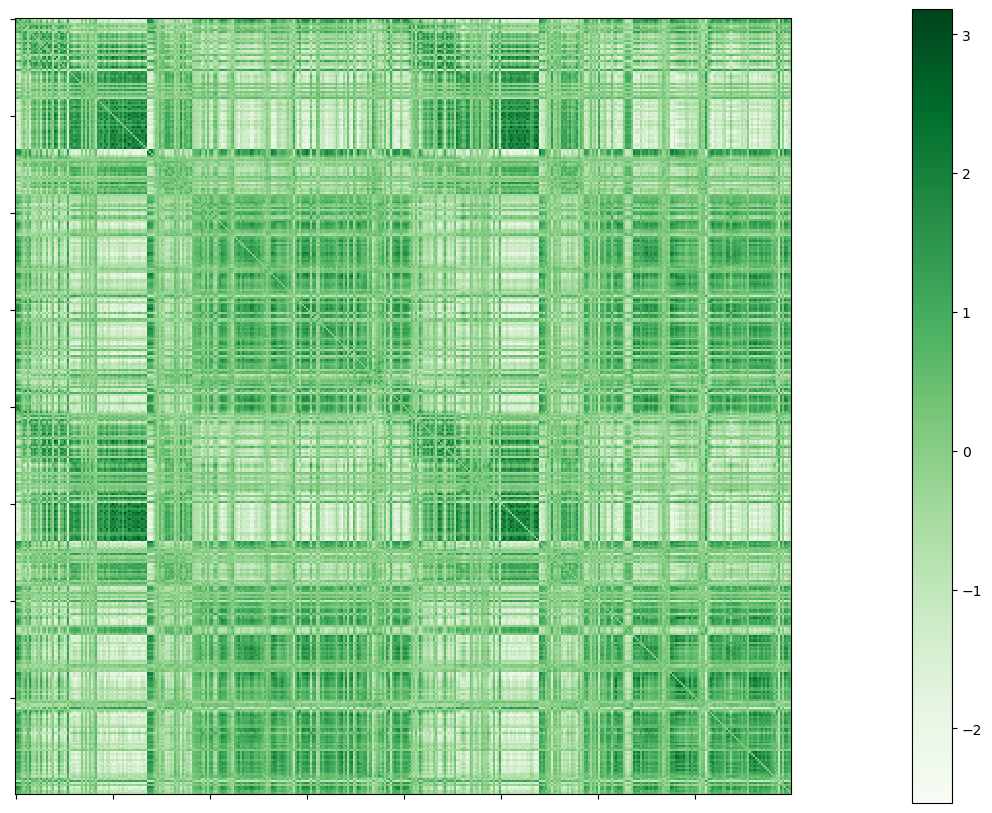

In [6]:
# Plot the mean MPC matrix
MPC_mean = np.mean(MPC, axis=2)
corr_plot = plotting.plot_matrix(MPC_mean, figure=(10, 10), labels=None, cmap='Greens')

In [7]:
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt

micapipe=os.environ['MICAPIPE']
# Here we define the atlas
atlas='schaefer-400'
# Load conte69
surf_lh, surf_rh = load_conte69()

# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/'+atlas+'_conte69.csv'), dtype=np.int)
Ndim = max(np.unique(labels_c69[0]))

# mask of the medial wall
mask_c69 = labels_c69 != 0

/opt/anaconda3/lib/python3.7/site-packages/vtk-8.1.2-py3.7-macosx-10.9-x86_64.egg/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [156]:
 # Calculate the gradients
Ngrad=5
gm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm.fit(MPC_mean, sparsity=0.8)

GradientMaps(kernel='normalized_angle', n_components=5)

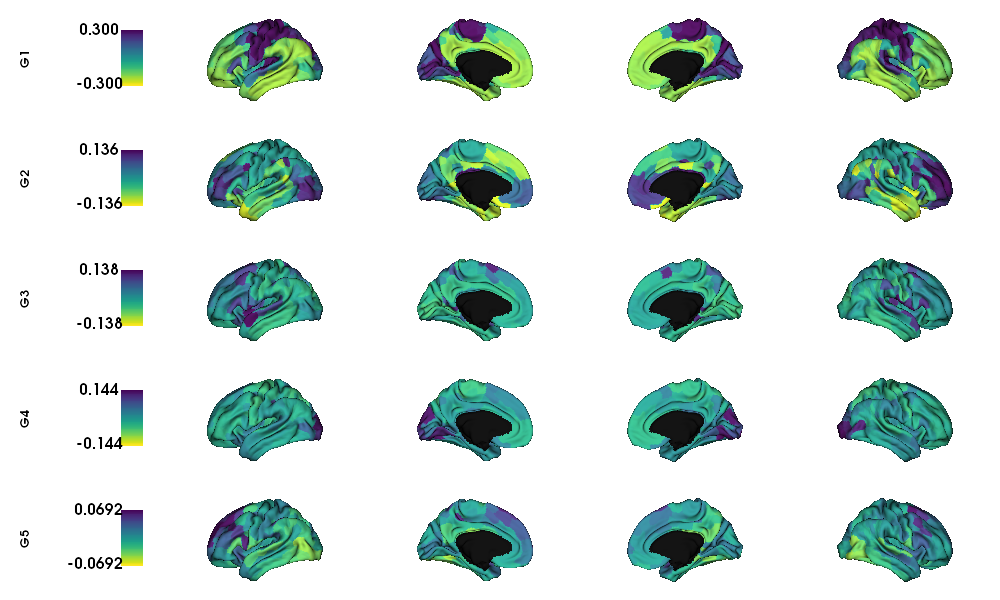

In [157]:
# Map gradients to original parcels
grad = [None] * Ngrad
for i, g in enumerate(gm.gradients_.T[0:Ngrad,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# Plot Gradients
ylab=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                  embed_nb=True,  label_text={'left':ylab}, color_bar='left',
                  zoom=1.25, nan_color=(0, 0, 0, 1), color_range='sym' )

In [69]:
from brainstat.datasets import fetch_parcellation
import h5py
from brainstat.context.histology import (
    download_histology_profiles,
    compute_histology_gradients,
    compute_mpc,
    read_histology_profile,
)

# Run the analysis
schaefer_400 = fetch_parcellation("fslr32k", "schaefer", 400)

# Download the histology profile from BigBrain
download_histology_profiles(data_dir='./', template='fslr32k', overwrite=True)


2023-09-11 21:58:28,388 - brainstat - INFO - Downloading histology_fslr32k.h5 from https://box.bic.mni.mcgill.ca/s/6zKHcg9xXu5inPR/download.


In [70]:
h5 = h5py.File('./histology_fslr32k.h5','r')
histology_profiles=h5['fs_LR_64k']

In [152]:
Ngrad=5
mpc = compute_mpc(histology_profiles, labels=schaefer_400)
gradient_map = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gradient_map.fit(mpc, sparsity=0.9)

GradientMaps(kernel='normalized_angle', n_components=5)

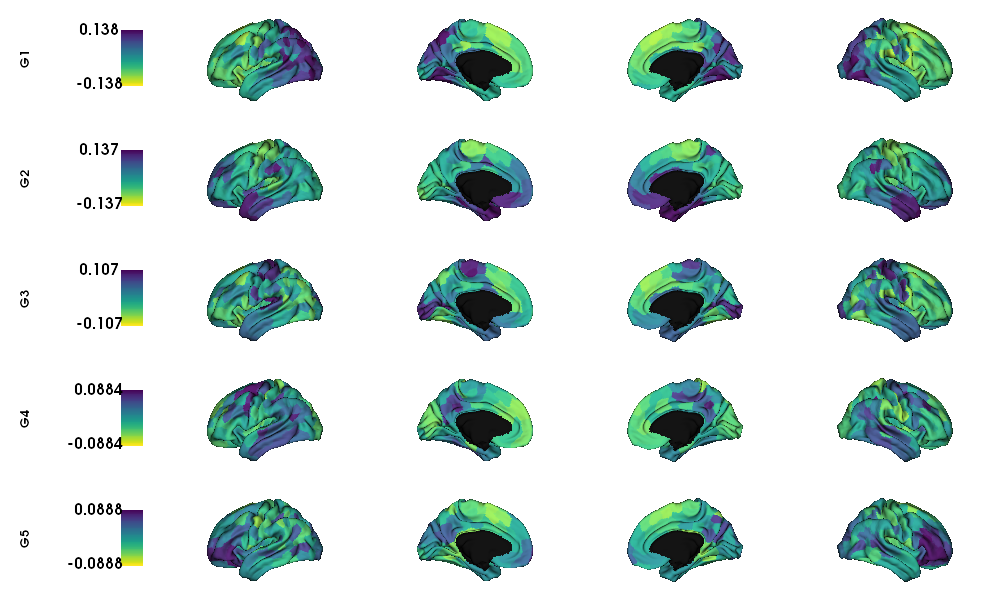

In [154]:
# Map gradients to original parcels
vertexwise_gradient = [None] * Ngrad
for i, g in enumerate(gradient_map.gradients_.T[0:Ngrad,:]):
    vertexwise_gradient[i] = map_to_labels(g, schaefer_400, fill=np.nan, mask=schaefer_400 != 0)

ylab=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(surf_lh, surf_rh, 
                 array_name=vertexwise_gradient, 
                 size=(1000, 600), 
                 cmap='viridis_r',
                  embed_nb=True,  
                 label_text={'left':ylab}, 
                 color_bar='left',
                 zoom=1.25, 
                 nan_color=(0, 0, 0, 1), 
                 color_range='sym' )

In [136]:
gm.gradients_.shape

(400, 3)

In [137]:
gradient_map.gradients_.shape

(400, 3)

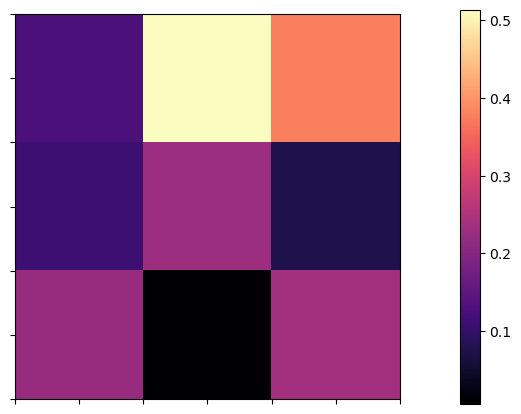

In [139]:
corr = np.corrcoef(gm.gradients_, gradient_map.gradients_, rowvar=False)
plotting.plot_matrix(np.abs(corr[:3,3:]), figure=(5, 5), labels=None, cmap='magma')

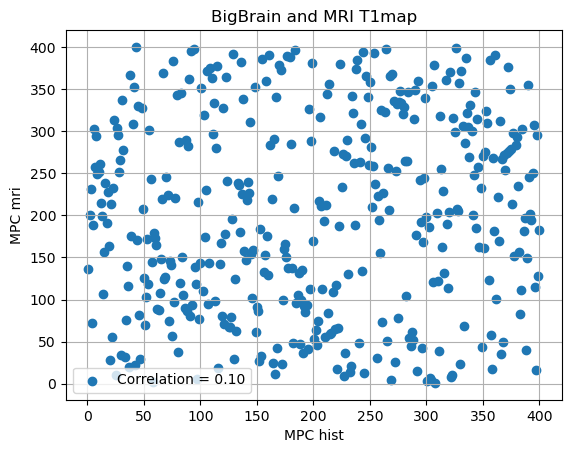

In [158]:
from scipy.stats import spearmanr
from scipy.stats import rankdata

# Calculate the correlation coefficient
g1_his = gradient_map.gradients_[:,0]
g1_mri = gm.gradients_[:,0]

# Remove NaN values
valid_indices = ~np.isnan(g1_his) & ~np.isnan(g1_mri)
g1_his = rankdata(g1_his[valid_indices])
g1_mri = rankdata(g1_mri[valid_indices])

# Calculate the Spearman rank correlation coefficient
correlation_coefficient, _ = spearmanr(g1_his, g1_mri)

# Create a scatter plot
plt.scatter(g1_his, g1_mri, label=f'Correlation = {correlation_coefficient:.2f}')
plt.xlabel('MPC hist')
plt.ylabel('MPC mri')
plt.title('BigBrain and MRI T1map')
plt.legend()
plt.grid(True)

In [178]:
from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud

meta_analysis = meta_analytic_decoder("fslr32k", vertexwise_gradient[0])
print(meta_analysis)

2023-09-12 12:45:47,461 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2023-09-12 12:45:48,442 - brainstat - INFO - Running correlations with all Neurosynth features.
                    Pearson's r
v1                     0.498663
selectivity            0.433506
lateral occipital      0.432782
object recognition     0.431299
sighted                0.430139
...                         ...
pain                  -0.359796
skin                  -0.373714
nerve                 -0.381102
nociceptive           -0.383450
noxious               -0.436722

[3228 rows x 1 columns]


In [181]:
wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

AttributeError: 'ImageDraw' object has no attribute 'textbbox'